# First Homework, Linear and Discrete Optimization Problem: Concert Revenue Maximization

#### Implemented by:
- Marina Gómez Rey (100472836)
- Miguel Fernández Lara (100473125)

*Group 96, Optimization and Analytics 2024*

<a id="0"></a> <br>
 ## Table of Contents  
1. [Linear Optimization Problem Statement](#1)

   1.1 [Dataset](#2)
   
   1.2 [Data Visualization](#3)
   
   1.3 [General Formulation](#4)

   1.4 [Implementation](#5)
   
   1.5 [Results](#6)
   
   1.6 [Sensitivities Analysis](#7)
   
2. [Mixed Integer Programming Optimization Problem](#8)

   4.1 [Dataset](#13)

   4.2 [General Formulation](#9)
   
   4.3 [Implementation](#10)
   
   4.4 [Results](#11)

4. [Final Conclusions](#12)

<a id="1"></a> <br>
## Linear Optimization Problem Statement

In a couple months, a stadium in Madrid will be hosting a concert in which thousands of people are expected to come. The organizers of the event are assigned to determine the price of the tickets in order to maximize the revenue. The goal of the organizers is to reach a ticket sold-out by appealling a large and varied audience. Therefore, the ticket prices should be carefully chosen to attract fans with different budgets. 

The audience will be organized in ten different sections inside the stadium, as shown in the picture below. The sections include VIP, general admission and economy (divided into 10 sections). The prices for each section need to fall within a specific range based on the location, amenities and demand elasticity. As an example, VIP seats, which are the closest ones to the stage, and include meet and greet, will be priced higher than general admission seats at the back, but both section prices must remain within reasonable bounds in order to avoid alienating potential ticket buyers. 

Inside each section, two types of tickets can be found: normal and reduced tickets. The reduced passes include children, people over 65 and citizens with dissabilities. The prices of the reduced tickets must be set within a 30% price reduction margin in comparison to the normal ones.

Although the main goal is to maximize revenue, the organizers must balance the average ticket price across the ten sections. However, this average must be divided into the Normal and Reduced prices to maintain consistency. This is done in order to avoid pricing out attendees. Therefore, a threshold must be set to predetermine the overall average ticket price, thus making the concert accessible to all citizens and ensuring high profitability. 

Moreover, in addition to the average price constraint, each section must contain a lower and upper bound for the prices in both the normal and reduced tickets.

Regardless of that, the areas are divided in prices categories, resulting in Expensive, Normal and Cheap prices. For each one of this, a minimum revenue must be set so that there is a minimum expected revenue acquired since the beginning.

The aim is to apply linear optimization techniques in order for the organizers to determine the most appropiate price for the tickets. This approach will ensure that the concert is financially profitable and acessible to all fans.



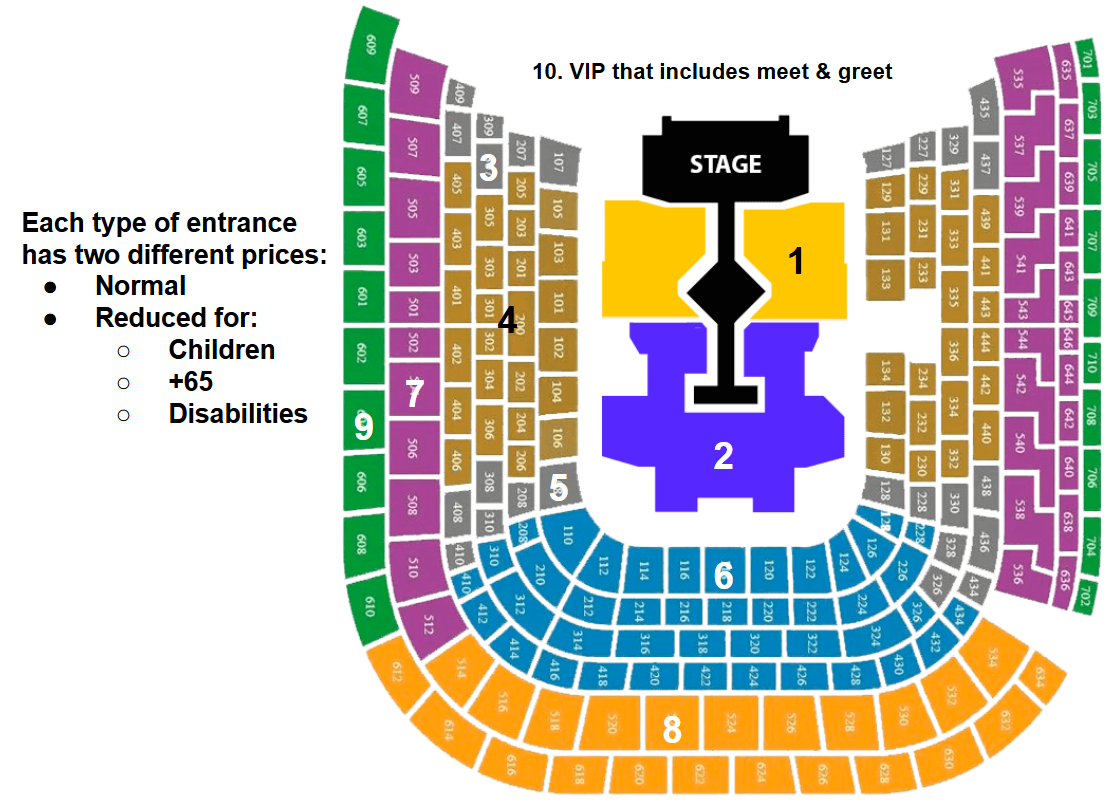

In [6]:
from IPython.display import Image

Image(filename='Images/1_concert_sections.PNG') 

The picture above shows the stadium with the different section numbers.

<a id="2"></a> 
## 1. Dataset

In order to organize the information, a database is created to show the capacity, expected demand, minimum price and maximum price per section.

In [9]:
import pandas as pd

file_path = 'Datasets/concert_prices.csv'

concert_data = pd.read_csv(file_path, delimiter=";")

concert_data.head() 

,Section,Ticket type,Capacity,Expected demand,Min price,Max price
0,1,Normal,1500,1000,150,250
1,1,Reduced,500,300,100,200
2,2,Normal,6000,4500,75,150
3,2,Reduced,1500,1000,50,100
4,3,Normal,4000,3750,125,200


#### Determine price categories 

One of the constraints that will be applied later depends on a minimum expected revenue from each category of the ticket prices, being these cheap, medium or expensive. 
In order to find the category for each ticket price, the following code makes a threshold that divides the prices based on the average and the 33 and 66 percentiles. This will be applied to the Normal ticket prices, as we assume that if the category is 'Expensive' in the Normal priced tickets, the Reduced will have the same category.

The computed column will be added to the initial dataset. 

In [11]:
# Filtering only the "Normal" tickets
normal_df = concert_data[concert_data['Ticket type'].str.contains("Normal")].copy()

# Calculating average price
normal_df.loc[:, 'Avg price'] = (normal_df['Min price'] + normal_df['Max price']) / 2

# Defining thresholds based on 33 and 66 percentiles within only "Normal" ticket types
cheap_threshold = normal_df['Avg price'].quantile(0.33)
expensive_threshold = normal_df['Avg price'].quantile(0.66)

# Categorize prices
def categorize_price(avg_price):
    if avg_price < cheap_threshold:
        return 'Cheap'
    elif avg_price > expensive_threshold:
        return 'Expensive'
    else:
        return 'Normal'

# Defining a new column in our database: Price Category
normal_df.loc[:, 'Price Category'] = normal_df['Avg price'].apply(categorize_price)

# Dropping average price, it is not necessary in the dataset
normal_df = normal_df.drop(columns = ['Avg price'])

normal_df.head()

,Section,Ticket type,Capacity,Expected demand,Min price,Max price,Price Category
0,1,Normal,1500,1000,150,250,Expensive
2,2,Normal,6000,4500,75,150,Normal
4,3,Normal,4000,3750,125,200,Expensive
6,4,Normal,10000,8000,110,175,Expensive
8,5,Normal,4500,3750,85,135,Normal


 Once the categories are defined, they are applied to the original concert dataset merging them by section and adding the price category

In [13]:
concert_data = concert_data.merge(normal_df[['Section', 'Price Category']],
                                  on='Section', how='left')

In [14]:
concert_data

,Section,Ticket type,Capacity,Expected demand,Min price,Max price,Price Category
0,1,Normal,1500,1000,150,250,Expensive
1,1,Reduced,500,300,100,200,Expensive
2,2,Normal,6000,4500,75,150,Normal
3,2,Reduced,1500,1000,50,100,Normal
4,3,Normal,4000,3750,125,200,Expensive
5,3,Reduced,500,300,65,125,Expensive
6,4,Normal,10000,8000,110,175,Expensive
7,4,Reduced,3500,2750,75,120,Expensive
8,5,Normal,4500,3750,85,135,Normal
9,5,Reduced,750,450,55,100,Normal


[Go back to Table of contents](#0)

<a id="3"></a> 
## Data Visualization 

In order to understand the problem, dataset and constraints better, visualizing the variables can be very helpful.

#### Capacity vs Demand

The following plot shows the capacity of each ticket price in a blue line, and the expected demand for that price in an orange line. 

It can be seen that the capacity for the reduced tickets is always smaller, in an attempt to have more revenue from offering more normal priced tickets. 
Besides, it will be shown more clearly in another graph, but the more expensive tickets have less capacity than the medium and the cheaper ones. 

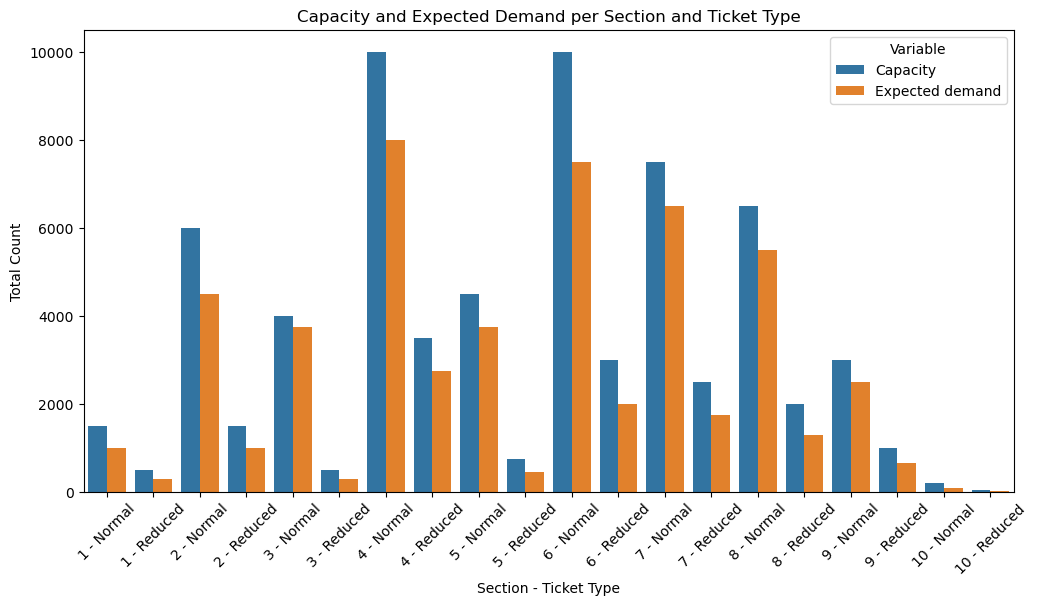

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a copy of the concert data just in case
df = pd.DataFrame(concert_data)

df['Section_Type'] = df['Section'].astype(str) + ' - ' + df['Ticket type']

plt.figure(figsize=(12, 6))

# Bar plot for Capacity and Expected demand
sns.barplot(
    data=pd.melt(df, id_vars=['Section_Type'], value_vars=['Capacity', 'Expected demand']),
    x='Section_Type', y='value', hue='variable', errorbar=None
)

plt.title('Capacity and Expected Demand per Section and Ticket Type')
plt.xlabel('Section - Ticket Type')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.legend(title='Variable')
plt.show()


#### Min and max prices

In the following boxplots we can have a better insight of the variation present in the ticket prices intervals.

The bounds of the normal tickets are: 
For the max price
* Upper = 190
* Lower = 120
* Mean = 145

For the min price:
* Upper = 125
* Lower = 70
* Mean = 85

The reduced tickets have a significant decrease in these bounds:
For the max price
* Upper = 125
* Lower = 90
* Mean = 105

For the min price:
* Upper = 70
* Lower = 50
* Mean = 60

This shows the importance of applying a mean price for all tickets, so that the difference across the different sections is not flagrant. On top of that, the mean should be different across these two categories, as their variations are very notable, so only one mean would not reflect the reality, as also the number of tickets of each category is very imbalanced.


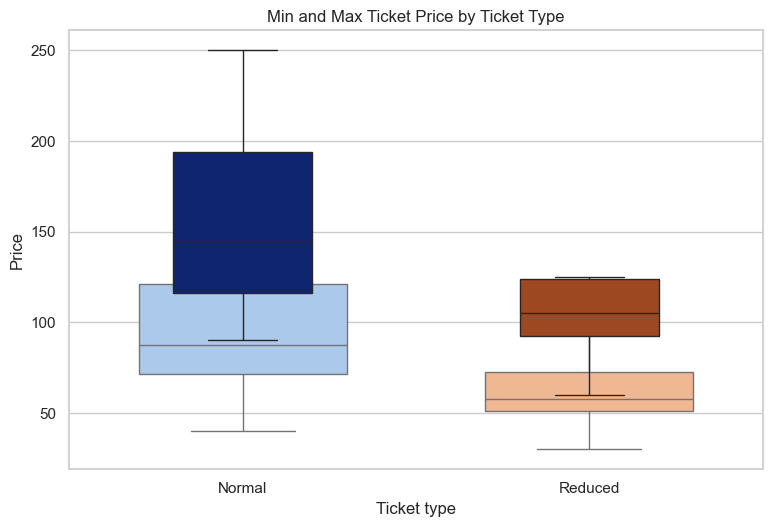

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Ticket type price range (min vs max)
plt.subplot(2, 2, 3)
sns.boxplot(x='Ticket type', y='Min price', data=concert_data, hue='Ticket type', palette="pastel", width=0.6, showfliers=False, legend=False)
sns.boxplot(x='Ticket type', y='Max price', data=concert_data, hue='Ticket type', palette="dark", width=0.4, showfliers=False, legend=False)
plt.title("Min and Max Ticket Price by Ticket Type")
plt.ylabel("Price")

plt.tight_layout()
plt.show()


#### Analysis of price categories

The following plots show the capacity and demand per ticket categories, and the boxplots for the ranges of the prices.

In order to understand better the distribution of the tickets, it can be seen that the category with the highest numer of tickets is the normal price, and the one with the smallest number is the expensive one. This is important to maintain the balance in the prices we have previously talked about. 

Moreover, regarding the min and max prices ranges for each category, the differences are very notable as expected, with higher prices for the expensive ones, and smaller for the cheaper ones. It is also interesting to note that the ranges for the more expensive tickets are higher than the normal and the cheaper are even tighter, as these tickets tend to have a more fixed and predictable pricing structure. This suggests that while the premium categories have more flexibility for adjustment based on demand, the lower-priced categories are likely designed to remain consistent to ensure accessibility for a wider audience.

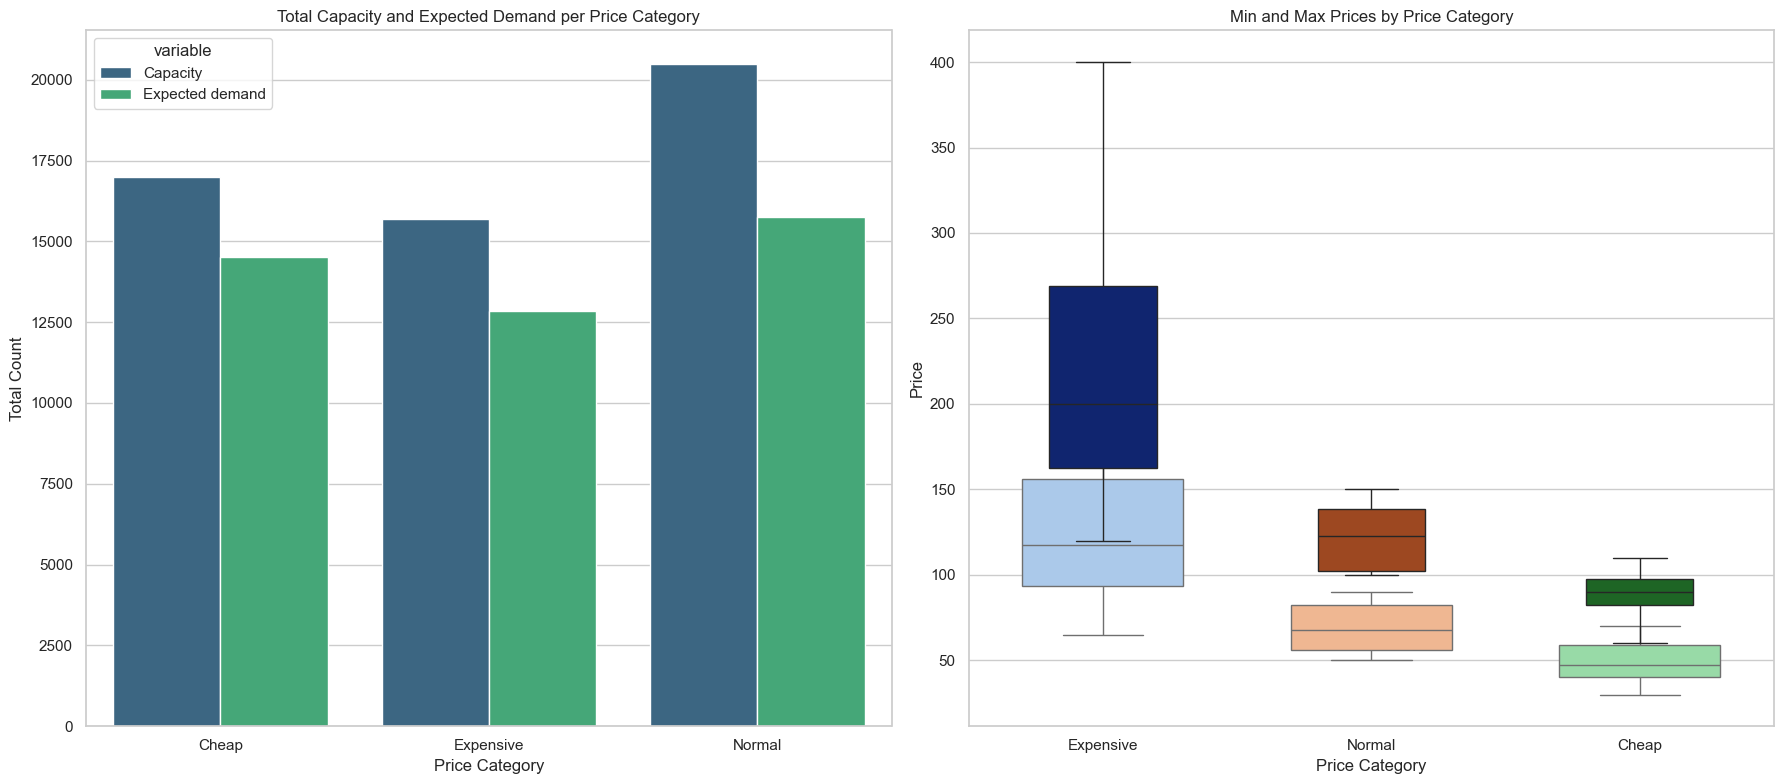

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 8))

# Bar Plot of Total Capacity and Expected Demand per Price Category
plt.subplot(1, 2, 1)
capacity_demand_df = normal_df.groupby('Price Category')[['Capacity', 'Expected demand']].sum().reset_index()
capacity_demand_df = pd.melt(capacity_demand_df, id_vars="Price Category", value_vars=["Capacity", "Expected demand"])
sns.barplot(x='Price Category', y='value', hue='variable', data=capacity_demand_df, palette="viridis")
plt.title("Total Capacity and Expected Demand per Price Category")
plt.xlabel("Price Category")
plt.ylabel("Total Count")

# Box Plot of Min and Max Prices by Price Category
plt.subplot(1, 2, 2)
sns.boxplot(x='Price Category', y='Min price', data=concert_data, hue='Price Category', palette="pastel", width=0.6, showfliers=False, dodge=False, legend=False)
sns.boxplot(x='Price Category', y='Max price', data=concert_data, hue='Price Category', palette="dark", width=0.4, showfliers=False, dodge=False, legend=False)
plt.title("Min and Max Prices by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Price")

plt.tight_layout()
plt.show()


[Go back to Table of contents](#0)

<a id="4"></a> <br>
## General Formulation

#### Optimization Problem: Maximizing Revenue from Ticket Sales

We are given a concert with $S = 10$ sections and two types of tickets for each section: $Normal$ and $Reduced$. The goal is to maximize the revenue from ticket sales, subject to several constraints.

#### Sets and Indices:

Let:
- $i \in \{1, 2, \dots, 10\} $  represent the sections of the concert venue.
- $j \in \{Normal, Reduced\} $  represent the ticket types.


#### Parameters:

We define the following parameters:
- $d_{ij}$ : The demand for tickets in section $ i $ and ticket type $ j $, i.e., the number of tickets expected to be sold.
- $L_{ij}$ : The minimum price for section $ i $ and ticket type $ j $.
- $U_{ij}$ : The maximum price for section $ i $ and ticket type $ j $.
- $Bj$ : The maximum allowed average ticket price across all sections and ticket types.


#### Decision Variables:

Define:
$$
P_{ij} \text{ is the price per section and ticket type (normal/reduced), where } i = 1, \ldots, 10 \text{ and } j = Normal, Reduced.
$$
Where:
- $ i $ represents different seating sections (1 to 10),
- $ j $ represents the ticket type (Normal or Reduced).


#### Objective Function:

The objective of this optimization problem is to **maximize the total revenue** generated from ticket sales across all sections of the concert venue.

Given:
- $ d_{ij} $ : The fixed demand (number of tickets expected to be sold) in section $ i $ and ticket type $ j $,
- $ P_{ij} $ : The ticket price for section $ i $ and ticket type $ j $, which is a decision variable we want to determine.

The total revenue can be calculated as the sum of the product of demand and price for each section and ticket type. In mathematical terms, the objective function is:


\begin{align*}
\underset{P_{ij}}{\max} & \quad Z = \sum_{i=1}^{10} \sum_{j \in \{\text{Normal}, \text{Reduced}\}} d_{ij} \cdot P_{ij} \\
\end{align*}

where $ Z $ represents the total revenue and the limits of the summation correspond to 0 = Normal and 1 = Reduced.


#### Constraints:


1. **Price Range Constraints:**

   Each ticket price must lie within the predefined bounds for each section and ticket type. These constraints are given by:

   $$
   L_{ij} \leq P_{ij} \leq U_{ij}, \quad \forall i = 1, \dots, 10, \quad j = Normal, Reduced
   $$

2. **Average Price Constraint:**

   The average ticket price across all sections and ticket types must not exceed a maximum value $ B $. This constraint is given by:

   $$
   \frac{1}{10} \sum_{i=1}^{10} P_{ij} \leq Bj \quad j = Normal, Reduced
   $$

   
   where 10 is the total number of sections and (Normal, Reduced) are ticket type combinations (10 sections * 2 ticket types).
   
4. **Minimum Revenue Constraints per Price Category:**

   Define revenue categories based on price levels (**expensive**, **normal**, or **cheap**) and require each category to meet a minimum revenue. 

   Let $R_{\text{min},k}$ be the minimum revenue required for each category $k$, where:

    $$
    k \in \{\text{expensive}, \text{normal}, \text{cheap}\}
    $$

    For each category $k$, we define a subset of indices $(i, j)$ corresponding to the sections and ticket types in that category. This constraint can be written as:

    $$
    \sum_{(i, j) \in k} d_{ij} \cdot P_{ij} \geq R_{\text{min},k} \quad \forall k \in \{\text{expensive}, \text{normal}, \text{cheap}\}
    $$



5. **Price Ratio Constraint between Normal and Reduced Tickets:**

   The reduced ticket price for each section should not be less than 70% of the normal ticket price for the same section. This ensures that the reduced tickets are consistently priced relative to the normal tickets:

   $$
   P_{i,\text{Reduced}} \geq 0.7 \cdot P_{i,\text{Normal}}, \quad \forall i = 1, \dots, 10
   $$



#### Summary:


\begin{align*}
\underset{P_{ij}}{\max} & \quad Z = \sum_{i=1}^{10} \sum_{j=0}^{1} d_{ij} \cdot P_{ij} \\
\text{s.t.:} & \\
& L_{ij} \leq P_{ij} \leq U_{ij}, \quad \forall i = 1, \dots, 10, \quad j = Normal, Reduced \\
& \frac{1}{10} \sum_{i=1}^{10} P_{ij} \leq Bj \quad j = Normal, Reduced \\
& \sum_{(i, j) \in k} d_{ij} \cdot P_{ij} \geq R_{\text{min},k} \quad \forall k \in \{\text{expensive}, \text{normal}, \text{cheap}\} \\
& P_{i,\text{Reduced}} \geq 0.7 \cdot P_{i,\text{Normal}}, \quad \forall i = 1, \dots, 10 \\
& P_{ij} \geq 0, \quad \forall i = 1, \dots, 10, \quad j = Normal, Reduced
\end{align*}



[Go back to Table of contents](#0)

<a id="5"></a> <br>
## Implementation

In [30]:
from pyomo.environ import *

#### Problem initialization

Firstly, create a concrete model and initialize the following sets: sections and price type.

In [33]:
model = ConcreteModel()

# Sets
model.sections = RangeSet(1, 10)  # 10 sections
model.price_types = Set(initialize=["Normal", "Reduced"])  # Normal and Reduced price types

Initializing the parameters: 

$ model.d $ represents the demand in the ticket sale. It will retrieve the expected demand from the database, transform it into a dictionary and set the integer for all sections and price types

In [35]:
# Parameters

# Ensure fixed demand is properly indexed by (section, ticket type)
fixed_demand = concert_data.groupby(['Section', 'Ticket type'])['Expected demand'].sum().to_dict()
model.d = Param(model.sections, model.price_types, initialize=fixed_demand, doc="Fixed demand per section and price type")

$model.L$ and $model.U$ represent the lower and upper bounds of the prices in each section and ticket type. 

In [37]:
# Making sure that the data is inside a dictionary for Pyomo to be able to process it
min_price = concert_data.groupby(['Section', 'Ticket type'])['Min price'].first().to_dict() 
max_price = concert_data.groupby(['Section', 'Ticket type'])['Max price'].first().to_dict()
model.L = Param(model.sections, model.price_types, initialize=min_price, doc="Minimum price per section and price type")
model.U = Param(model.sections, model.price_types, initialize=max_price, doc="Maximum price per section and price type")

$model.Bj$ initializes the maximum average price we must set for all the entrances. This will work as a regularization parameter. The prices of the entrances should be moderate for them to be accessible to all society

In [39]:
# Maximum allowed average normal ticket price
BNormal = 115  
model.BNormal = Param(initialize=BNormal, mutable = True, doc="Maximum average for normal ticket price")

# Maximum allowed average reduced ticket price
BReduced = 80  
model.BReduced = Param(initialize=BReduced, mutable = True, doc="Maximum average for reduced ticket price")

The last parameters will set a minimum revenue per price category, using the budget divisions established during the data understanding process. This will ensure that each group of tickets will ensure a prefixed revenue. The numbers used in this setting are an estimation of the possible revenue from a real concert.

In [41]:
# Min revenues across categories
min_revenue_expensive = 2100000  
min_revenue_normal = 1800000
min_revenue_cheap = 1200000

model.min_revenue_expensive = Param(initialize=min_revenue_expensive, mutable = True, doc="Minimum revenue for expensive category")
model.min_revenue_normal = Param(initialize=min_revenue_normal, mutable = True, doc="Minimum revenue for normal category")
model.min_revenue_cheap = Param(initialize=min_revenue_cheap, mutable = True, doc="Minimum revenue for cheap category")

Finally, initialize the decision variables, $model.p$, which has two iterators: $i$, for the total number of sections; and $j$, for the two ticket prices established. In this specific problem set, the stadium has 10 different sections. Therefore, the problem will have 20 decision variables.

Here we also add the positive values trivial constraint. This is done by adding the domain "NonNegativeReals".

In [43]:
# Ticket price for each section and price type
model.p = Var(model.sections, model.price_types, domain=NonNegativeReals, doc="Ticket price per section and price type")

#### Objective function

The objective function is set to maximize the total revenue. This is done by optimizing the sum over the product of the demand and the price of a specific section $i$ and ticket type $j$.

In [46]:
def objective_rule(model):
    return sum(model.d[i, j] * model.p[i, j] for i in model.sections for j in model.price_types)
model.revenue = Objective(rule=objective_rule, sense=maximize, doc="Maximize total revenue")

#### Constraints

**1. Minimum and maximum price constraint**

   These two constraints set a lower and upper bound for the price of the tickets, taking into account the ticket type. 
   

In [49]:
# Minimum price constraints for each section and price type
def min_price_rule(model, i, j):
    return model.p[i, j] >= model.L[i, j]
model.price_constraints_min = Constraint(model.sections, model.price_types, rule=min_price_rule, 
                                         doc="Minimum price per section and price type")

# Maximum price constraints for each section and price type
def max_price_rule(model, i, j):
    return model.p[i, j] <= model.U[i, j]
model.price_constraints_max = Constraint(model.sections, model.price_types, rule=max_price_rule, 
                                         doc="Maximum price per section and price type")

**2. Average price constraint**

   In order to ensure a realistic scenario of a concert, we would need to adjust the mean of entrances' prices. This is done in order to ensure that the mean is a reasonable price for all fans to be able to afford at least one of the section prices. It has to be divided into the both ticket types because the average of the reduced must be lower.

In [51]:
# For normal tickets 
def avg_price_normal_rule(model):
    return (sum(model.p[i, "Normal"] for i in model.sections) / len(model.sections)) <= model.BNormal
model.avg_price_normal_constraint = Constraint(rule=avg_price_normal_rule, doc="Limit on average normal ticket price")

# For reduced tickets
def avg_price_reduced_rule(model):
    return (sum(model.p[i, "Reduced"] for i in model.sections) / len(model.sections)) <= model.BReduced
model.avg_price_reduced_constraint = Constraint(rule=avg_price_reduced_rule, doc="Limit on average reduced ticket price")

**3. Minimum revenue per category**

For each price category analyzed beforehand, we need to define a minimum revenue we expect to get, in order to ensure profitability from the concert. The constraint is ensuring that the product of the demand and prices in each catergory are strictly larger than the minimum revenue.

In [53]:
# Sections 1, 3, 4, 10 belong to expensive
def min_revenue_expensive_rule(model):
    return sum((model.d[i, j] * model.p[i, j]) for i in [1, 3, 4, 10] for j in model.price_types) >= model.min_revenue_expensive
model.min_revenue_expensive_rule = Constraint(rule=min_revenue_expensive_rule, doc="Minimum revenue for expensive category")

# Sections 2, 5, 6 belong to normal
def min_revenue_normal_rule(model):
    return sum((model.d[i, j] * model.p[i, j]) for i in [2, 5, 6] for j in model.price_types) >= model.min_revenue_normal
model.min_revenue_normal_rule = Constraint(rule=min_revenue_normal_rule, doc="Minimum revenue for normal category")

# Sections 7, 8, 9 belong to cheap
def min_revenue_cheap_rule(model):
    return sum((model.d[i, j] * model.p[i, j]) for i in [7, 8, 9] for j in model.price_types) >= model.min_revenue_cheap
model.min_revenue_cheap_rule = Constraint(rule=min_revenue_cheap_rule, doc="Minimum revenue for cheap category")

**4. Maximum difference between normal and reduced prices**

The reduced prices must be controlled within a predefined range in order to ensure profitability. In this case, the reduced price should not be lower than a 30% of the normal price for each specific section. 

In [55]:
def max_price_difference_rule(model, i):
    return model.p[i, "Reduced"] >= model.p[i, "Normal"] * 0.7
model.max_price_difference_rule = Constraint(model.sections, rule=max_price_difference_rule, doc="Limit on differences between normal and reduced ticket prices")

#### Solving the model

In [57]:
solver = SolverFactory('glpk')
result = solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmpntghy5s_.glpk.raw
 --wglp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp954d1ild.glpk.glp
 --cpxlp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmplkydt146.pyomo.lp
Reading problem data from '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmplkydt146.pyomo.lp'...
55 rows, 20 columns, 100 non-zeros
314 lines were read
Writing problem data to '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp954d1ild.glpk.glp'...
253 lines were written
GLPK Simplex Optimizer 5.0
55 rows, 20 columns, 100 non-zeros
Preprocessing...
15 rows, 20 columns, 60 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  8.000e+03  ratio =  8.000e+04
GM: min|aij| =  3.128e-01  max|aij| =  3.197e+00  ratio =  1.022e+01
EQ: min|aij| =  9.954e-02  max|aij| =  1.000e+00  ratio =  1.005e+01
Constructing initial basis...
Size of triangular part is 15
      0: obj =   4.3

#### Outcome

In [59]:
# Extracting optimal prices for each (section, ticket type) combination
optimal_prices = {
    (i, j): model.p[i, j].value for i in model.sections for j in model.price_types
}

# Calculating the total revenue by summing the demand for each (section, ticket type) combination
total_revenue = sum(model.d[i, j] * model.p[i, j].value for i in model.sections for j in model.price_types)

print("Optimal Prices per Section and Ticket Type:")
for i in model.sections:
    for j in model.price_types:
        print(f"  Section {i}, Ticket Type {j}: {optimal_prices[(i, j)]:.2f}€")

print("\nTotal Revenue: {:,.2f}€".format(total_revenue))


Optimal Prices per Section and Ticket Type:
  Section 1, Ticket Type Normal: 150.00€
  Section 1, Ticket Type Reduced: 105.00€
  Section 2, Ticket Type Normal: 75.00€
  Section 2, Ticket Type Reduced: 52.50€
  Section 3, Ticket Type Normal: 125.00€
  Section 3, Ticket Type Reduced: 87.50€
  Section 4, Ticket Type Normal: 146.24€
  Section 4, Ticket Type Reduced: 102.37€
  Section 5, Ticket Type Normal: 85.00€
  Section 5, Ticket Type Reduced: 59.50€
  Section 6, Ticket Type Normal: 119.60€
  Section 6, Ticket Type Reduced: 83.72€
  Section 7, Ticket Type Normal: 89.16€
  Section 7, Ticket Type Reduced: 62.41€
  Section 8, Ticket Type Normal: 60.00€
  Section 8, Ticket Type Reduced: 42.00€
  Section 9, Ticket Type Normal: 42.86€
  Section 9, Ticket Type Reduced: 30.00€
  Section 10, Ticket Type Normal: 250.00€
  Section 10, Ticket Type Reduced: 175.00€

Total Revenue: 5,158,147.92€


[Go back to Table of contents](#0)

<a id="6"></a> <br>
## Results

In order to analyze the results some plots will be computed:

1. Top Left - **Optimal Prices per Section and Ticket Type**

   This bar chart shows the optimal ticket prices across different sections, categorized by ticket type (Normal and Reduced).

2. Top Right - **Optimal Price vs Capacity**
   
   This scatter plot shows the relationship between the optimal price and the capacity for each section.

3. Bottom Left - **Total Revenue per Section**

   This bar chart shows the total revenue generated for each section.

4. Bottom Right - **Total Revenue by Price Category**
   
   This bar chart shows the total revenue generated by different price categories (Cheap, Expensive, and Normal).


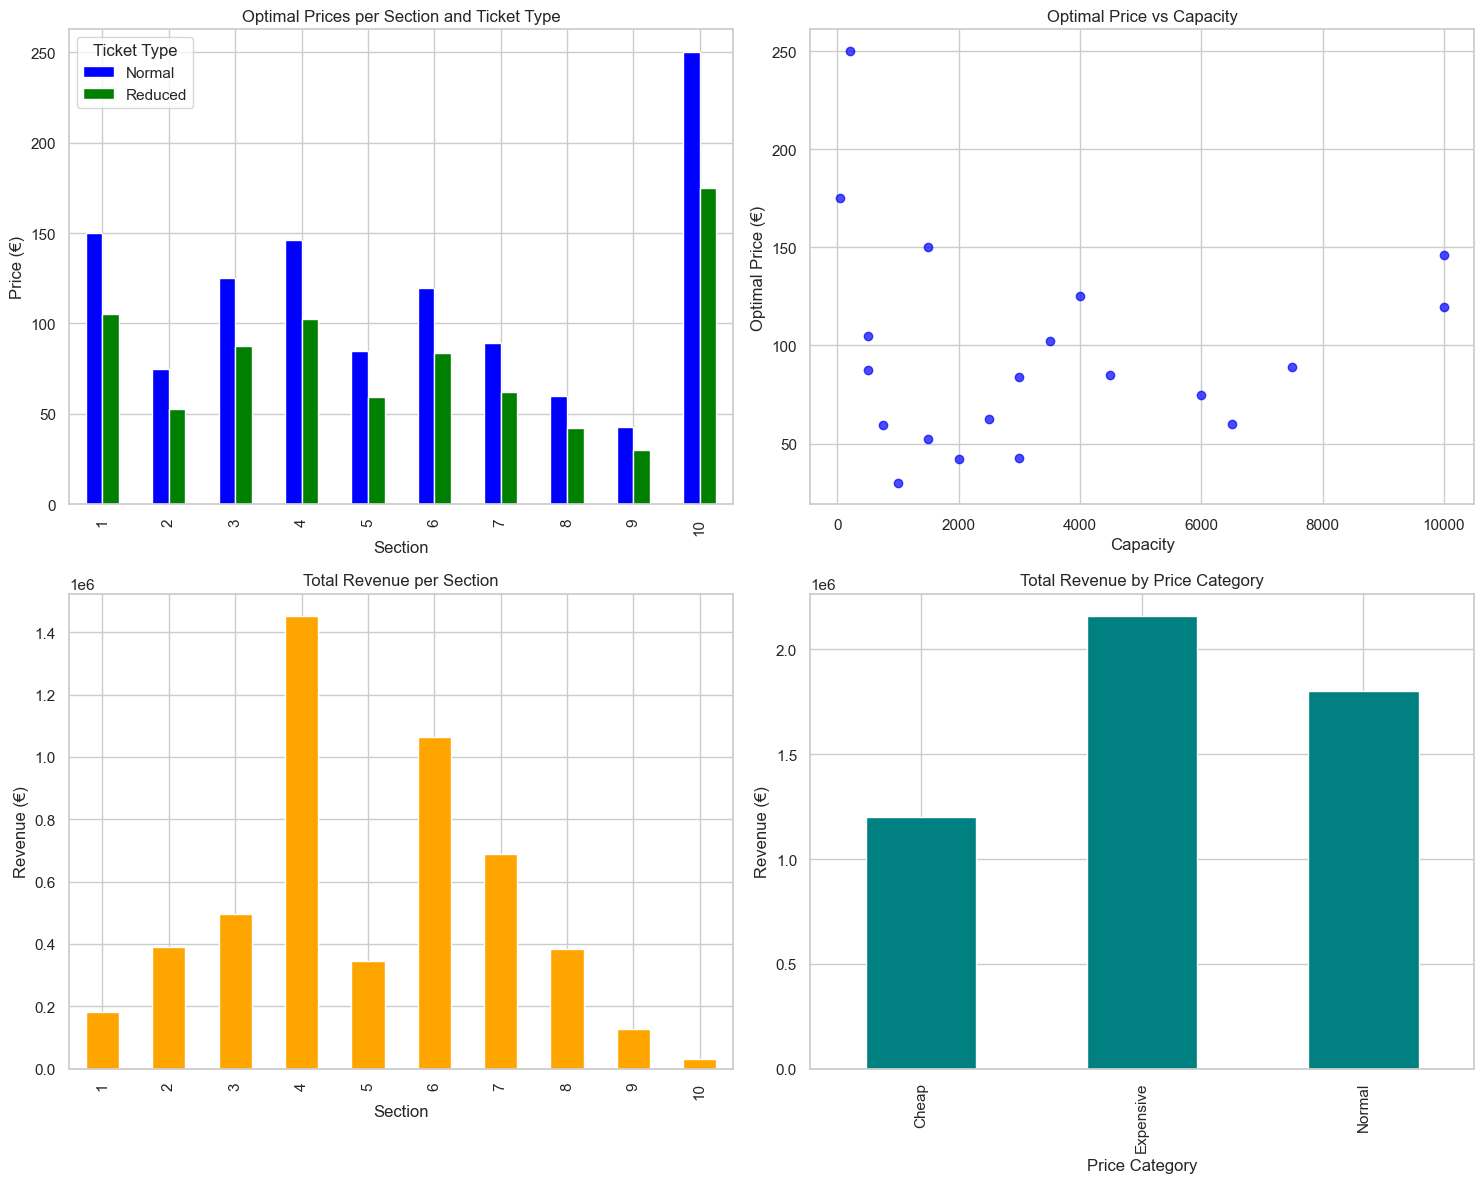

In [63]:
# We create a copy dataframe in order to avoid changing the original one
df = concert_data.copy()

# Strip extra spaces in column names if there are any to avoid errors
df.columns = df.columns.str.strip()

# Creating a dictionary with the results of the ticket prices
optimal_prices = {
    (1, 'Normal'): 150.00,
    (1, 'Reduced'): 105.00,
    (2, 'Normal'): 75.00,
    (2, 'Reduced'): 52.50,
    (3, 'Normal'): 125.00,
    (3, 'Reduced'): 87.50,
    (4, 'Normal'): 146.24,
    (4, 'Reduced'): 102.37,
    (5, 'Normal'): 85.00,
    (5, 'Reduced'): 59.50,
    (6, 'Normal'): 119.60,
    (6, 'Reduced'): 83.72,
    (7, 'Normal'): 89.16,
    (7, 'Reduced'): 62.41,
    (8, 'Normal'): 60.00,
    (8, 'Reduced'): 42.00,
    (9, 'Normal'): 42.86,
    (9, 'Reduced'): 30.00,
    (10, 'Normal'): 250.00,
    (10, 'Reduced'): 175.00,
}

# Adding a new column for optimal prices in the dataframe
df['Optimal price'] = df.apply(
    lambda row: optimal_prices.get((row['Section'], row['Ticket type']), None), axis=1
)

# Calculating total revenue (Expected demand * Optimal price)
df['Revenue'] = df['Expected demand'] * df['Optimal price']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Visualization:

# 1. Optimal Price by Ticket Type (Bar Chart)
df_pivot = df.pivot(index='Section', columns='Ticket type', values='Optimal price')
df_pivot.plot(kind='bar', ax=axes[0, 0], color=['blue', 'green'])
axes[0, 0].set_title('Optimal Prices per Section and Ticket Type')
axes[0, 0].set_xlabel('Section')
axes[0, 0].set_ylabel('Price (€)')
axes[0, 0].legend(title='Ticket Type')

# 2. Optimal Price vs Capacity (Simple Scatter Plot)
axes[0, 1].scatter(df['Capacity'], df['Optimal price'], color='blue', alpha=0.7)
axes[0, 1].set_title('Optimal Price vs Capacity')
axes[0, 1].set_xlabel('Capacity')
axes[0, 1].set_ylabel('Optimal Price (€)')

# 3. Total Revenue per Section (Bar Chart)
df_total_revenue = df.groupby('Section')['Revenue'].sum()
df_total_revenue.plot(kind='bar', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Total Revenue per Section')
axes[1, 0].set_xlabel('Section')
axes[1, 0].set_ylabel('Revenue (€)')

# 4. Total Revenue by Price Category (Bar Chart)
df_price_category_revenue = df.groupby('Price Category')['Revenue'].sum()
df_price_category_revenue.plot(kind='bar', ax=axes[1, 1], color='teal')
axes[1, 1].set_title('Total Revenue by Price Category')
axes[1, 1].set_xlabel('Price Category')
axes[1, 1].set_ylabel('Revenue (€)')

plt.tight_layout()
plt.show()


### Analysis

- Regarding the **Optimal Prices per Section and Ticket Type** (Top Left Chart):

  We can see that, as expected, the Reduced type ticket prices are smaller than the normal type ones. 
  Sections like 1, 3, 4, and 10 have notably higher "Normal" prices compared to others, as also expected, because they belong to the expensive category. 10 is the most expensive, as the VIP section should be. Besides, the cheaper ones (7, 8, 9) have lower prices.

- Regarding the **Optimal Price vs. Capacity** (Top Right Chart):

  This scatter plot reveals that, although there is not a straightforward relationship between capacity and optimal price, there are some patterns.

  There are higher prices in lower-capacity sections (e.g., sections around 0-2000 in capacity) which happen to coincide with the more expensive tickets, that have less offered tickets. On the other hand, some high-capacity sections are priced lower, as they coincide with cheap and normal prices, that have also more demand. This suggests a demand-sensitive pricing strategy. 

- Regarding the **Total Revenue per Section** (Bottom Left Chart):

  Revenue generation is highly concentrated in certain sections, notably sections 4, 5, and 6. Section 4, in particular, generates the highest revenue,  due to the combination of optimal pricing belonging to the expensive class and high demand. Sections 5 and 6 belong to the normal category, which has a higher concentration of seats as the prices are more affordable for the public, and also not as cheap as to not give enough revenue, so it makes sense that these provide more revenue.

  Sections like 1, 8, and 10 also contribute significant revenue but to a lesser extent, indicating they are important for overall revenue yet there is less amount of available tickets (sections 1 and 10) or the prices are less expensive (section 8).

  Sections like 7 and 9 generate less revenue, due to lower ticket demand, less desirable seating, or lower optimal pricing. This highlights areas where future strategies, such as promotional pricing or package deals, could help increase occupancy and revenue.

- Regarding the **Total Revenue by Price Category** (Bottom Right Chart):

  The "Expensive" category generates the most revenue. Although there are less tickets, the prices make this category very profitable.
  The "Normal" category also contributes significantly, supporting a balanced pricing strategy that allows for accessibility to a broader audience while still maintaining substantial revenue.
  The "Cheap" category, while contributing the least, plays a role in maximizing occupancy and making tickets accessible, which might be essential for overall attendance, customer satisfaction, and filling up less popular sections.

##### Overall Insights:

The model seems to balance capacity, demand, and price optimization by adjusting ticket prices across sections and categories. High-demand sections and the ones with the best characteristics (VIP, better view) are priced higher, while lower-demand sections adopt more accessible pricing to ensure occupancy.
This balance allows that a broader amount of clients are able to go to the concert, as there are prices for people willing to pay more for better experiences and for the ones with a tighter budget.

The constraints have proven to be significant to achieve the objective of balancing the prices so that there are not extreme differences between the prices of the tickets while obtaining a significant revenue. 

There are sections that provide very high price results, while others like 7 or 9 provide less revenue, indicating that a further analysis of the prices intervals, demand and capacity could be helpful to make them work better.

As a result, based on the minimum revenue constraints, the concert woult provide a revenue of 4,100,000 €. However, with the optimization solution, we would acquire 5,158,147.92€, which is a significant improvement that shows the importance of optimizing this type of problems.

[Go back to Table of contents](#0)

<a id="7"></a> <br>
# Sensitivities Analysis

In order to study the sensitivities and perform the analysis, the model needs to be run again using the dual approach.

### Introduction: Dual Values

In order to interpret the model constraints’ effects on the maximization of the revenue, we must analyze the **dual values** associated with each specific constraint. Therefore, we must define the dual price. The dual value (shadow price) $\alpha_{c}$ of a constraint $c$ quantifies the amount of change in the optimized value of the objective function (maximum revenue), $Z$,  per unit increase in the constraint’s right-hand side. We can define two types of constraints:

1. **Binding Constraints**: Thesea are constraints with dual values different from zero. They actively contribute to the outcome of the revenue. As an example, if $\alpha_{c} \neq 0$ and negative for a minimum price constraint, then raising the minimum price would affect revenue negatively.
2. **Non-binding Constraints**: Constraints with dual values close to zero, are non-binding or weakly binding. Relaxing or setting more strict values for these constraints would not impact the revenue optimization radically. For instance, a weakly binding constraint would be $\alpha_{c} = -0.1152$, because it has minimal impact on revenue.


In [69]:
# Dual approach
model.dual = Suffix(direction=Suffix.IMPORT) 

solver = SolverFactory('glpk')  
result = solver.solve(model, tee=True)

# Showing again the results in the same way as in the previous section
optimal_prices = {
    (i, j): model.p[i, j].value for i in model.sections for j in model.price_types
}
total_revenue = sum(model.d[i, j] * model.p[i, j].value for i in model.sections for j in model.price_types)
print("Optimal Prices per Section and Ticket Type:")
for i in model.sections:
    for j in model.price_types:
        print(f"  Section {i}, Ticket Type {j}: {optimal_prices[(i, j)]:.2f}€")

print("\nTotal Revenue: {:,.2f}€".format(total_revenue))


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmpr2oeahoh.glpk.raw
 --wglp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp96dzkcu5.glpk.glp
 --cpxlp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp6oyw6lpf.pyomo.lp
Reading problem data from '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp6oyw6lpf.pyomo.lp'...
55 rows, 20 columns, 100 non-zeros
314 lines were read
Writing problem data to '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp96dzkcu5.glpk.glp'...
253 lines were written
GLPK Simplex Optimizer 5.0
55 rows, 20 columns, 100 non-zeros
Preprocessing...
15 rows, 20 columns, 60 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  8.000e+03  ratio =  8.000e+04
GM: min|aij| =  3.128e-01  max|aij| =  3.197e+00  ratio =  1.022e+01
EQ: min|aij| =  9.954e-02  max|aij| =  1.000e+00  ratio =  1.005e+01
Constructing initial basis...
Size of triangular part is 15
      0: obj =   4.3

The following code takes the dual values of each constraint in the model and displays it in an organized way for us to be able to draw conclusions of the outcome.

In [71]:
# Sensitivity Analysis (Dual Values)

# Minimum Price Constraints Duals
print("\nMinimum Price Constraints Duals:")
for i in model.sections:
    for j in model.price_types:
        try:
            dual_value = model.dual[model.price_constraints_min[i, j]]
            print(f"  Section {i}, Ticket Type {j} (Min): Dual = {dual_value:.4f}")
        except KeyError:
            print(f"  Section {i}, Ticket Type {j} (Min): No dual value available")

# Maximum Price Constraints Duals
print("\nMaximum Price Constraints Duals:")
for i in model.sections:
    for j in model.price_types:
        try:
            dual_value = model.dual[model.price_constraints_max[i, j]]
            print(f"  Section {i}, Ticket Type {j} (Max): Dual = {dual_value:.4f}")
        except KeyError:
            print(f"  Section {i}, Ticket Type {j} (Max): No dual value available")

# Average Price Constraints Duals
print("\nAverage Price Constraints Duals:")
# Normal Ticket Average Price Constraint
try:
    dual_value = model.dual[model.avg_price_normal_constraint]
    print(f"  Normal Ticket: Dual = {dual_value:.4f}")
except KeyError:
    print("  Normal Ticket: No dual value available")

# Reduced Ticket Average Price Constraint
try:
    dual_value = model.dual[model.avg_price_reduced_constraint]
    print(f"  Reduced Ticket: Dual = {dual_value:.4f}")
except KeyError:
    print("  Reduced Ticket: No dual value available")

# Minimum Revenue Constraints Duals
print("\nMinimum Revenue Constraints Duals:")
# Expensive category (sections 1, 3, 4, 10)
try:
    dual_value = model.dual[model.min_revenue_expensive_rule]
    print(f"  Expensive Category (1, 3, 4, 10): Dual = {dual_value:.4f}")
except KeyError:
    print("  Expensive Category (1, 3, 4, 10): No dual value available")

# Normal category (sections 2, 5, 6)
try:
    dual_value = model.dual[model.min_revenue_normal_rule]
    print(f"  Normal Category (2, 5, 6): Dual = {dual_value:.4f}")
except KeyError:
    print("  Normal Category (2, 5, 6): No dual value available")

# Cheap category (sections 7, 8, 9)
try:
    dual_value = model.dual[model.min_revenue_cheap_rule]
    print(f"  Cheap Category (7, 8, 9): Dual = {dual_value:.4f}")
except KeyError:
    print("  Cheap Category (7, 8, 9): No dual value available")

# Maximum Price Difference Constraint Duals
print("\nMaximum Price Difference Constraints Duals:")
for i in model.sections:
    try:
        dual_value = model.dual[model.max_price_difference_rule[i]]
        print(f"  Section {i}: Dual = {dual_value:.4f}")
    except KeyError:
        print(f"  Section {i}: No dual value available")



Minimum Price Constraints Duals:
  Section 1, Ticket Type Normal (Min): Dual = -8715.0000
  Section 1, Ticket Type Reduced (Min): Dual = 0.0000
  Section 2, Ticket Type Normal (Min): Dual = -4126.1236
  Section 2, Ticket Type Reduced (Min): Dual = 0.0000
  Section 3, Ticket Type Normal (Min): Dual = -5965.0000
  Section 3, Ticket Type Reduced (Min): Dual = 0.0000
  Section 4, Ticket Type Normal (Min): Dual = 0.0000
  Section 4, Ticket Type Reduced (Min): Dual = 0.0000
  Section 5, Ticket Type Normal (Min): Dual = -5391.8399
  Section 5, Ticket Type Reduced (Min): Dual = 0.0000
  Section 6, Ticket Type Normal (Min): Dual = 0.0000
  Section 6, Ticket Type Reduced (Min): Dual = 0.0000
  Section 7, Ticket Type Normal (Min): Dual = 0.0000
  Section 7, Ticket Type Reduced (Min): Dual = 0.0000
  Section 8, Ticket Type Normal (Min): Dual = -1689.4984
  Section 8, Ticket Type Reduced (Min): Dual = 0.0000
  Section 9, Ticket Type Normal (Min): Dual = 0.0000
  Section 9, Ticket Type Reduced (Min

### Analysis

The dual values of the constraint represent the marginal benefit (price per ticket) of relaxing each constraint. When the output of the dual value is positive, it means that relaxing the constraint (lowering or increasing depending on the constraint) will increase the profit in the objective function. On the other hand, if the dual value is negative, it indicates that setting a more strict value for the constraint will decrease the value maximized by the objective function. The ideal scenario is to have dual values close to 0.

1. **Minimum Price Constraint Duals**

    The sections that present a negative dual value (Sections 1, 2, 3, 5, 8, 9, and 10) have a binding minimum price, which means that the solution is highly sensitive to any increase in that specific variable. Therefore, a rise in the minimum price in those sections would reduce revenue.

    Nevertheless, sections with a dual value of 0 (Sections 4, 6, 7) have a non binding constraint, which means that the price can be freely adjusted without seeing radical changes in the revenue of the problem.

2. **Maximum Price Constraint Duals**
   
   Following the logic from the previous constraint and given that all sections have a dual value of 0, we can conclude the price can be freely set without seeing changes in the revenue. This is because the average price constraint does not allow the prices to go beyond the ones established, as the average would increase a lot, making it not suitable for the public.

3. **Average Price Constraint Duals**

    The average price for the normal tickets is not binding, since the values of the dual are 0. Therefore, we can freely adapt that parameter. However, the constraint on reduced ticket prices is relevant, and the relaxation of this constraint would provide a significant increase in revenue, which is very attractive. Thus, the outcome indicates that there is room to increase the price of reduced tickets without violating the revenue maximization objective.

4. **Minimum Revenue Constraint Duals**

   As we can see in the three values for the three price categories, they are all around 0, which means that they are not binding. The normal and cheap categories show a slightly different outcome from the expensive one, presenting a negative dual value. This means that relaxing this constraint would have a positive impact on revenue, since it is a minimum constraint. But, again, it is trivial, since it is close to 0.

5. **Maximum Price Difference Between Normal and Reduced Constraint Duals**

    Every section shows a positive dual value. However, they vary across sections, with the highest value observed in Section 1 (13,878.57) and the lowest in Section 10 (142.86). This constraint is highly binding, as we can see in the large values shown. This means that relaxing the difference between Normal and Reduced prices will drastically increase the revenue, since this constraint is a maximum. Section number 10 would show the less impact if increasing the increment between the normal and reduced prices.


### Recommendations

If another iteration of this problem were to be made, the organizers of the concert should follow these recommendations:

- Don't increase minimum ticket prices in the sections where we found that the constraint varies negatively the revenue outcome, particularly for normal tickets and the reduced of section 10. 
- Relax (decrease) the maximum price difference between normal and reduced tickets in the sections where high dual values are shown in order to capture additional revenue
- Increase the average price constraint for reduced tickets in order to increase revenue.
   
   

[Go back to Table of contents](#0)

<a id="8"></a> <br>
## Mixed Integer Problem Statement

Once the prices of the tickets are established, the other part of the revenue will come from the placement of several stands where refreshments will be sold. These posts can sell one of the following three products:

* Drinks
* Snacks
* Fast food (FF)

We have nine possible placements for these stands, as shown in the image below, and each stand can only sell one type of product. Each one will give a different revenue and for administrative reasons there is a limit in the number of each type of stand there can be. For example, as fast food requieres more ingredients and logistic, there can only be two. For the other two, there can be a maximum of four. 

Note that not every location must be occupied, there may be locations without any refreshment point, which would mean that it is not profitable to install it in that specific location.  

Also, there are four possible placements for deliverers that distribute drinks along some specific delimited areas of the stadium. However, they can only operate if they can refill the drinks in a near stand.

The objective is to maximize the revenue obtained from these stands, choosing the best placements and types for each one.

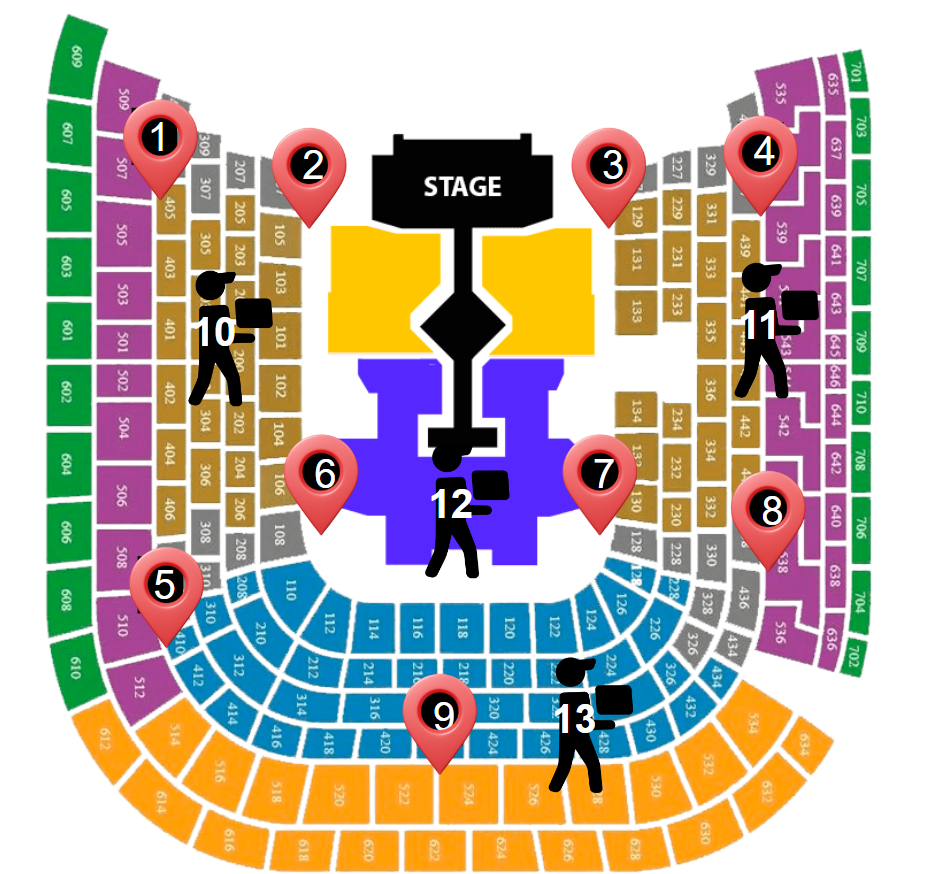

In [77]:
Image(filename='Images/2_locations_refreshments.PNG') 

[Go back to Table of contents](#0)

<a id="13"></a> <br>
## New Dataset

First, let's see the dataset.

In [81]:
import pandas as pd
df = pd.read_csv("Datasets/refreshers_location.csv", delimiter=';')
df

,ID,Location,Product,Profit,Not with,Depends on
0,1,1,Snack,10000,"2, 3, 4",NaN
1,2,1,Drink,5000,"1, 3, 5",NaN
2,3,1,FF,7500,"1, 2, 6",NaN
3,4,2,Snack,11000,"5, 6, 1",NaN
4,5,2,Drink,5500,"4, 6, 2",NaN
5,6,2,FF,8000,"4, 5, 3",NaN
6,7,3,Snack,11000,"8, 9, 10",NaN
7,8,3,Drink,5500,"7, 9, 11",NaN
8,9,3,FF,8000,"7, 8, 12",NaN
9,10,4,Snack,12000,"11, 12, 7",NaN


We can see that for each location there are three rows, one for each product type. These are the possible options for a specific location.

Besides, the profit for each is established, which already includes the costs for hiring a company to install the food, the waiters and the rest of the staff. The profit of each refresher is unique in each case. The profit does not depend on category, they are independent from each other.

Finally, there are two columns with 'Not with' and the dependencies. 'Not with' means that if that stand is placed, the stands that appear in that row are not available in that specific location. The dependencies mean that you need at least one of the stands that appear on that list to be located in order to be able to put that other refresher. This last constraint is linked with the employees that deliver drinks to the atendees.

<a id="9"></a> <br>
## General Formulation

### Sets and Indices

Let:
- $l \in \text{locations}$: The set of unique locations in the concert stadium, where $l = 1, \dots, 13$.
- $i \in \text{options}_l$: The set of refreshment stand options available at each location $l$.

### Parameters

Define the limits on the number of each type of stand across the stadium:
- $\text{Min\_snacks}$, $\text{Max\_snacks}$: Minimum and maximum number of snack stands.
- $\text{Min\_drinks}$, $\text{Max\_drinks}$: Minimum and maximum number of drink stands.
- $\text{Min\_ff}$, $\text{Max\_ff}$: Minimum and maximum number of fast food stands.
  
For each option $i$ at each location $l$:
- $\text{Profit}_{i,l}$: The profit generated by selecting option $i$ at location $l$.
- $\text{Location}_{i,l}$: This ensures that the item selected $i$ has the correct location $j$.
- $\text{Product}_{i,l}$: The refresher type of the item $i$ at location $j$. 
- $\text{Not\_with}_{i,l}$: A set of options that cannot be selected together with option $i$ at location $l$.
- $\text{Depends\_on}_{i,l}$: A set of options required to be active if option $i$ is selected.



### Decision Variables

Define a binary decision variable $x_{i,l}$ for each option $i$ at each location $l$:
$$
x_{i,l} = \begin{cases} 
1, & \text{if option } i \text{ is chosen at location } l \\
0, & \text{otherwise}
\end{cases}
$$

### Objective Function

Maximize the total profit from selected options across all locations:
$$
\underset{x}{\max} \quad Z = \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l} \text{Profit}_{i,l} \cdot x_{i,l}
$$

### Constraints

1. **Single Option per Location Constraint**:

   Ensure that only one option is chosen per location:
   $$
   \sum_{i \in \text{options}_l} x_{i,l} \leq 1, \quad \forall l \in \text{locations}
   $$

2. **Product Count Constraints**:

   For each product type, the number of selected stands must fall within specified limits.

   For snacks:
   $$
   \text{Min\_snacks} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = Snack}} x_{i,l} \leq \text{Max\_snacks}
   $$

   For drinks:
   $$
   \text{Min\_drinks} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = Drink}} x_{i,l} \leq \text{Max\_drinks}
   $$

   For fast food:
   $$
   \text{Min\_ff} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = FF}} x_{i,l} \leq \text{Max\_ff}
   $$

3. **Mutual Exclusivity Constraints**:

   Ensure mutual exclusivity between options in the $\text{Not\_with}$ sets:
   $$
   x_{i,l} + x_{j,l} \leq 1, \quad \forall i, j \in \text{Not\_with}_{i,l}
   $$

4. **Dependency Constraints**:

   If an option $i$ depends on other options, ensure that those dependencies are active:
   $$
   x_{i,l} \leq \sum_{j \in \text{Depends\_on}_{i,l}} x_{j,l}
   $$

5. **Binary Constraints**:

   Each decision variable $x_{i,l}$ is binary:
   $$
   x_{i,l} \in \{0, 1\}, \quad \forall i \in \text{options}_l, \quad \forall l \in \text{locations}
   $$

Summary:

\begin{align*}
\underset{x}{\max} \quad Z = & \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l} \text{Profit}_{i,l} \cdot x_{i,l} \\
\text{s.t.:} & \\
\quad & \sum_{i \in \text{options}_l} x_{i,l} \leq 1, \quad \forall l \in \text{locations} \\
\text{Snacks:} \quad & \text{Min\_snacks} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = Snack}} x_{i,l} \leq \text{Max\_snacks} \\
\text{Drinks:} \quad & \text{Min\_drinks} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = Drink}} x_{i,l} \leq \text{Max\_drinks} \\
\text{Fast Food:} \quad & \text{Min\_ff} \leq \sum_{l \in \text{locations}} \sum_{i \in \text{options}_l, \text{ product = FF}} x_{i,l} \leq \text{Max\_ff} \\
\quad & x_{i,l} + x_{j,l} \leq 1, \quad \forall i, j \in \text{Not\_with}_{i,l} \\
\quad & x_{i,l} \leq \sum_{j \in \text{Depends\_on}_{i,l}} x_{j,l} \\
\quad & x_{i,l} \in \{0, 1\}, \quad \forall i \in \text{options}_l, \quad \forall l \in \text{locations}
\end{align*}


[Go back to Table of contents](#0)

<a id="10"></a> <br>
## Implementation

Importing pyomo library again just in case the kernel was restarted for this part

In [88]:
from pyomo.environ import *

#### Problem initialization

Initialize the concrete model and define the sets. These sets will be: the locations in the stadium ($model.locations$), that will be numbers from 1-13; and the options to choose from the dataset ($model.options$). 

Note that the options are not separated into different locations because we want to ensure that every category is handled in the most optimal way. This is due to the use of drink refillers, that don't have the same format as the rest of categories. This approach is an error handler and avoids confussion in the pyomo model. Nevertheless, in every latter use of this set, there will always be a checker to ensure that the item corresponds to the right location.

In [91]:
model = ConcreteModel()

# Define sets
model.locations = Set(initialize=df['Location'].unique())  
model.options = Set(initialize=df['ID'].tolist())          

Now we define the parameters. 

Firstly, we need to set a maximum and minimum value for the different refreshment stands.

$model.Product$ is used in order to determine the type of stand in each observation in the dataset.

$model.Location$ is crucial to know which item belongs to each location.

$model.Profit$ is a parameter to store the values of unique revenues in each item. 

$model.Notwith$ retrieves the list of incompatibilities of each item in the dataset. This will be crucial for imposing the logical coditions

$model.Depends_on$ saves the list of dependencies. The only items with dependencies are the drinks' refillers.

In [93]:
# Define limits
min_snacks, max_snacks = 1, 4
min_drinks, max_drinks = 1, 4
min_ff, max_ff = 1, 2

model.min_snacks_val = Param(initialize=min_snacks)
model.max_snacks_val = Param(initialize=max_snacks)
model.min_drinks_val = Param(initialize=min_drinks)
model.max_drinks_val = Param(initialize=max_drinks)
model.min_ff_val = Param(initialize=min_ff)
model.max_ff_val = Param(initialize=max_ff)

# Retrieve the columns of the dataset and initialize parameters
model.Product = Param(model.options, initialize={row['ID']: row['Product'] for _, row in df.iterrows()}, within=Any)
model.Location = Param(model.options, initialize={row['ID']: row['Location'] for _, row in df.iterrows()}, within=NonNegativeIntegers)
model.Profit = Param(model.options, initialize={row['ID']: row['Profit'] for _, row in df.iterrows()}, within=NonNegativeIntegers)
model.Not_with = Param(model.options, initialize={row['ID']: [int(i) for i in row['Not with'].split(',')] if pd.notnull(row['Not with']) else [] for _, row in df.iterrows()}, within=Any)
model.Depends_on = Param(model.options, initialize={row['ID']: [int(i) for i in row['Depends on'].split(',')] if pd.notnull(row['Depends on']) else [] for _, row in df.iterrows()}, within=Any)

$model.x$ defines the desicion variables, which will be the binary. They will be a 1 if the stand is placed, and 0 otherwise. The location is implied when placing the item.

In [95]:
# Decision variables
model.x = Var(model.options, domain=Binary)

#### Objective function

This time, the objective is to maximize the revenue of the refreshment spots. The objective function will be the sum of the product of each decision variable (0 or 1) and the profit for that specific item. Only one refreshment type can be chosen per location.

In [98]:
def total_profit_rule(model):
    return sum(model.Profit[i] * model.x[i] for i in model.options)
model.total_profit = Objective(rule=total_profit_rule, sense=maximize)

#### Constraints

**1. Uniqueness constraint per location**

Each location must have only one stand chosen. This is crucial to avoid overlapping. It checks if the item is in the correct location.

In [101]:
# Only one option per location
def single_option_per_location_rule(model, l):
    return sum(model.x[i] for i in model.options if model.Location[i] == l) <= 1
model.single_option_per_location = Constraint(model.locations, rule=single_option_per_location_rule)

**2. Minimum and maximum constraints**

For each type of refreshment (food, snack and drink), a lower and upper bound is set for the quantity expected inside the stadium. 

In [103]:
def min_snacks_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'Snack') >= model.min_snacks_val
model.min_snacks_constraint = Constraint(rule=min_snacks_rule)

def max_snacks_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'Snack') <= model.max_snacks_val
model.max_snacks_constraint = Constraint(rule=max_snacks_rule)

def min_drinks_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'Drink') >= model.min_drinks_val
model.min_drinks_constraint = Constraint(rule=min_drinks_rule)

def max_drinks_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'Drink') <= model.max_drinks_val
model.max_drinks_constraint = Constraint(rule=max_drinks_rule)

def min_ff_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'FF') >= model.min_ff_val
model.min_ff_constraint = Constraint(rule=min_ff_rule)

def max_ff_rule(model):
    return sum(model.x[i] for i in model.options if model.Product[i] == 'FF') <= model.max_ff_val
model.max_ff_constraint = Constraint(rule=max_ff_rule)




**2. Mutual exclusivity constraints**

This is a logical constraint that determines the correct and adequate placement of refreshments. There are three options for each location, apart from the drink refillers, therefore if one is chosen the others must be discarted. Besides, two refreshments of the same type cannot be placed in consequtive locations, ensuring great variety of refreshment spots.

In [105]:
# Mutual exclusivity constraints
model.exclusivity = ConstraintList()
for i in model.options:
    for j in model.Not_with[i]:
        model.exclusivity.add(model.x[i] + model.x[j] <= 1)

**3. Dependency constraints**

As stated in the problem formulation, there are some workers inside the stadium delivering drinks to the users. These workers need to be close to a drinks area in order to be able to refill its inventory. Therefore, a logical dependency constraint must be set to ensure that the workers placed are close enough to the drinks spot.

In [107]:
# Dependency constraints
model.dependencies = ConstraintList()
for i in model.options:
    if model.Depends_on[i]:
        model.dependencies.add(model.x[i] <= sum(model.x[j] for j in model.Depends_on[i]))

#### Solving the model

In [109]:
solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmpkbciy0w1.glpk.raw
 --wglp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmpp9ckjbz9.glpk.glp
 --cpxlp /var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp7ezcxov7.pyomo.lp
Reading problem data from '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp7ezcxov7.pyomo.lp'...
/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp7ezcxov7.pyomo.lp:639: warning: lower bound of variable 'x2' redefined
/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmp7ezcxov7.pyomo.lp:639: warning: upper bound of variable 'x2' redefined
101 rows, 31 columns, 264 non-zeros
31 integer variables, all of which are binary
670 lines were read
Writing problem data to '/var/folders/jz/xzxdswbn76sfk1z4c9sv1sr80000gp/T/tmpp9ckjbz9.glpk.glp'...
531 lines were written
GLPK Integer Optimizer 5.0
101 rows, 31 columns, 264 non-zeros
31 integer variables, all of which are binary
Preproces

#### Outcome

In [111]:
# Display results
print("Status:", results.solver.termination_condition)
print("Total Profit:", model.total_profit.expr())
print("Selected options:")
for i in model.options:
    if model.x[i].value == 1:
        print(f"Option {i}: Location {model.Location[i]}, Product {model.Product[i]}, Profit {model.Profit[i]}")


Status: optimal
Total Profit: 97500.0
Selected options:
Option 4: Location 2, Product Snack, Profit 11000
Option 9: Location 3, Product FF, Profit 8000
Option 10: Location 4, Product Snack, Profit 12000
Option 15: Location 5, Product FF, Profit 9500
Option 16: Location 6, Product Snack, Profit 15000
Option 20: Location 7, Product Drink, Profit 7500
Option 22: Location 8, Product Snack, Profit 13000
Option 26: Location 9, Product Drink, Profit 6000
Option 30: Location 12, Product Drink, Profit 8000
Option 31: Location 13, Product Drink, Profit 7500


[Go back to Table of contents](#0)

<a id="11"></a> <br>
## Results

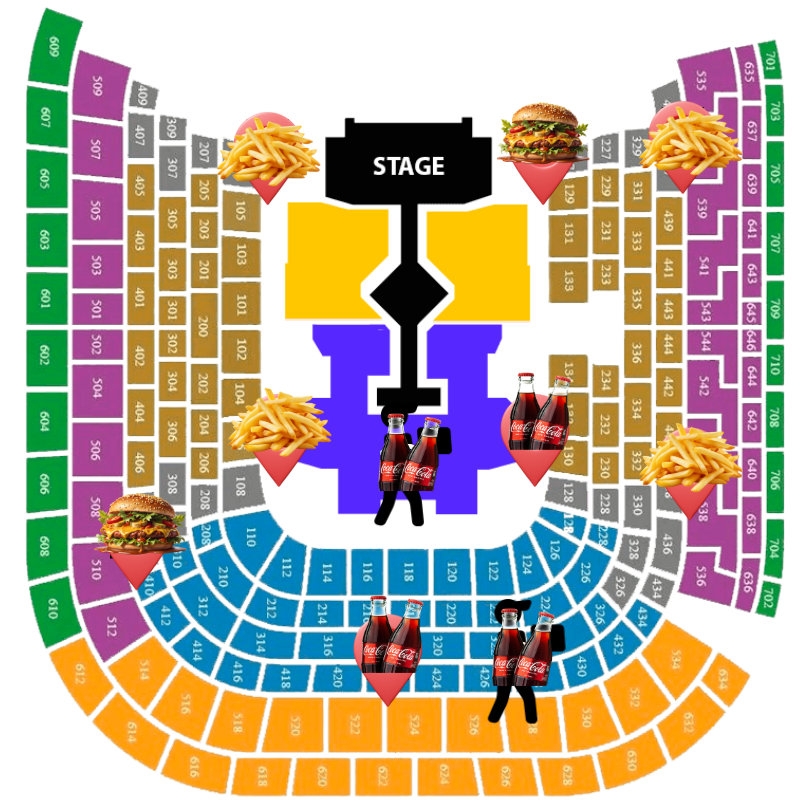

In [114]:
Image(filename='Images/3_solutions_refreshments.PNG') # Display concert image

### Analysis

As shown in the picture, the refreshment spots are fairly distributed around the stadium, ensuring that all atendees are able to access at least one of the snack, drink or fast food points. This also prevents congestion. Each color-coded has its own spot, apart from section 9, which is the cheapest and furthest section of all. Nevertheless, there are nearby spots in which users can buy refreshments.

It is evident that the most common type of stand selected is the snack stand, as it generally yields the highest revenue across various locations (For example, €15,000 for Location 6 and €13,000 for Location 8). On top of that, the selected locations are the ones that provided the most revenue from the possibilities.

In location 9, however, the drink stand generates higher revenue, due in part to its ability to accommodate a delivery service. The addition of a deliverer allows this stand to serve to more people and gaining more revenue than any of the other two options alone. As a result, the drink stand is chosen as the optimal option for this location.

For other locations, the decision remains on whether to allocate space for two fast food stands or to opt for a drink stand with a deliverer. This choice is made based on an analysis of expected revenue for each configuration.

We can observe that the minimum and maximum constraints for each type of refreshment spot were fulfilled. The selection chosen maximizes profit and sticks to the limits proposed.

Finally, due to the overall limits on the number of each type of stand that can be placed, stand number 1 is ultimately excluded from the final arrangement. This decision ensures that the available stands are allocated in a way that maximizes revenue across all locations while adhering to placement constraints.


[Go back to Table of contents](#0)

<a id="12"></a> <br>

# Final Conclusions

The goal of this project is to apply the linear optimization techniques we learnt in class into a real life problem, including the formulation, implementation and analysis.

The problem chosen is a concert revenue maximization, in which we succesfully achieve the goal to obtain the optimal value for concert ticket prices (in the linear optimization part), and the optimal locations and types of food stands in the stadium (in the discrete section). The organizers of a concert in this stadium could follow our approach to maximize their revenue, making a balance between obtaining as much revenue as possible and having attractive prices for people with different budgets. Not only that, but the organizers of other types of events, such as theatres, festivals or parties could use a similar approach. They should also follow the advices seen in the sensitivity analysis to obtain the best possible results.

Regarding the linear problem, it was achieved with constraints such as obtaining an average of the prices, having bounds for each category, obtaining a minimum revenue and controlling the difference between the Normal and Reduced prices. These constraints proved to be very helpful, as the obtained revenue is a 25% bigger than the expected one.

On top of that, sensitivity analysis was also computed to see how the modified constraints would change the outcome, revealing ways in which we could enhance the dataset or the constraints to obtain more revenue or make an even more optimal model. This analysis showed the importance of the chosen constraints and showed that the model is robust.

On the other hand, for the mixed integer problems, where the variables were binary, many constraints came from the dependencies and "not with" conditions to place the stands in an optimal way. Besides, because of logistic reasons, there was a maximum number for each type of stand. Having done this, the revenue obtained was almost 100,000€.

Overall, the problem implementation is a straightforward task once the sets, parameters, objective function and constraints are thoroughly thought. The first thing to do is to formulate the mathematical setting, in order to understand the problem. Then, translating the math into python was also fairly straightformward, following the models of the exercises we have already computed in class.

In future modifications for this problem, maybe the organizers could create a non-linear constraints and a non-linear objective function in order to analyse and capture further insights to maximize the revenue. Besides, there are other areas for future exploration, such as including dynamic pricing mechanisms to adjust ticket prices in real time based on sales progress, or competitive market conditions. Other possible ways of investigting further would be to take into account factors such as the weather or last-minute cancellations.

The part we struggled the most with was thinking about what idea to implement. We needed to invent a problem setting that differed substantially with the ones done in class, since we wanted an original idea. Furthermore, the idea needed to have the possibility to meet the requirements given. Once the idea was decided, another issue was creating the datasets from scratch, as we did not know if the solutions would make sense. Actually, we had the problem of not having a feasible solution several times, but adjusting the data and the constraints this was solved properly.

As a final conclusion, this project highlights the potential of optimization problems and the importance they have to generate optimal solutions that serve the purpose they are created for. In our specific case, our approach could maximize profitability, but also ensured accessibility for all types of clients, no matter if their budgets are smaller or larger.